<a href="https://colab.research.google.com/github/pablosierrafernandez/Crea-un-Portafolio-de-Acciones-estable-y-autom-tico/blob/main/Crea_un_Portafolio_de_Acciones_estable_y_autom%C3%A1tico_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔨 Crear un Portafolio de Acciones estable y automático.

La idea principal detrás del algoritmo es construir un portafolio de inversión óptimo, seleccionando y asignando pesos a diferentes acciones para maximizar el rendimiento ajustado al riesgo (medido por el ratio de Sharpe). Esto se logra mediante la descarga de datos históricos, la optimización numérica de los pesos de las acciones y el análisis de métricas clave para evaluar el desempeño del portafolio.

**Descarga de Datos**:
   - La función `download_data` descarga los datos históricos de precios ajustados de las acciones listadas en `nasdaq_symbols_list` usando la biblioteca `yfinance` para un rango de fechas especificado.
   - Los datos se almacenan en un diccionario y se maneja una lista de símbolos fallidos si ocurre algún error durante la descarga.

**Preparación de Datos**:
   - Los datos descargados se reindexan para alinear todas las series temporales a un rango de fechas completo y se llenan los valores faltantes con forward fill y backward fill.
   - Los datos alineados se concatenan en un único DataFrame.

**Cálculo de Retornos**:
   - Se calculan los retornos diarios de las acciones a partir de los precios ajustados.

**Optimización del Portafolio**:
   - La función `optimize_portfolio` utiliza optimización numérica para encontrar la combinación de pesos de las acciones que maximiza el ratio de Sharpe, que es una medida de rendimiento ajustada al riesgo.
   - La función `negative_sharpe_ratio` calcula el negativo del ratio de Sharpe dado un conjunto de pesos, y esta función se minimiza para encontrar la mejor combinación de pesos.

**Filtrado y Normalización de Pesos**:
   - Los pesos optimizados se filtran para considerar solo aquellos que son mayores a un umbral mínimo (`minimun_weight`) y se normalizan para asegurar que sumen a uno.

**Cálculo de Métricas del Portafolio**:
   - Se calculan el retorno anualizado, la volatilidad anualizada y el ratio de Sharpe del portafolio usando los pesos filtrados.
   - Se calcula el coeficiente de determinación (R²) del portafolio ajustado.

**Simulación y Visualización del Portafolio**:
   - Se simula el valor del portafolio a lo largo del tiempo con un capital inicial dado.
   - Se generan varios gráficos para visualizar el desempeño del portafolio, los pesos de las acciones seleccionadas, los retornos diarios y la distribución de retornos.

**Impresión de Resultados**:
   - Finalmente, se imprimen métricas importantes del portafolio, incluyendo el retorno anual, la volatilidad anual, el ratio de Sharpe, el valor final del portafolio y los pesos de cada acción en el portafolio.

   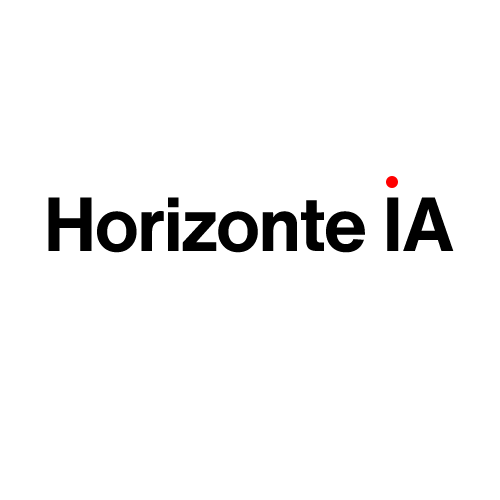

   https://www.youtube.com/@horizonte_ia


## 1. Install

In [1]:
!pip install pytickersymbols
!pip install deap
!pip install alpaca-py
!pip install alpaca_trade_api

  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytickersymbols 1.13.0 requires PyYAML==6.0, but you have pyyaml 6.0.1 which is incompatible.


## 2. Imports

In [2]:
from pytickersymbols import PyTickerSymbols
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from tqdm import tqdm
from deap import base, creator, tools, algorithms
import random
import alpaca_trade_api as tradeapi
import alpaca
from alpaca.data.live.stock import *
from alpaca.data.historical.stock import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.trading.client import *
from alpaca.trading.stream import *
from alpaca.trading.requests import *
from alpaca.trading.enums import *
from alpaca.common.exceptions import APIError
from datetime import datetime, timedelta
import time

## 3. Market Selection

In [3]:
def get_unique_symbols(indexes):
    stock_data = PyTickerSymbols()
    unique_symbols = set()

    for index in indexes:
        stocks = stock_data.get_stocks_by_index(index)
        symbols = [stock['symbol'] for stock in stocks]
        unique_symbols.update(symbols)

    return list(unique_symbols)

# Ejemplo de uso:
indexes = ['NASDAQ 100']#['NASDAQ 100', 'DOW JONES', 'S&P 500']
stock_names = get_unique_symbols(indexes)
print(stock_names)



print(len(stock_names))



#################################################
start_date = '2023-06-29'
end_date = '2024-06-29'
#################################################
initial_capital = 10000
#################################################
minimun_weight = 0.02 # minimo de % admitido

['NVDA', 'LRCX', 'SWKS', 'PYPL', 'REGN', 'INTC', 'DXCM', 'NFLX', 'TMUS', 'DDOG', 'PEP', 'PDD', 'SPLK', 'LCID', 'BIIB', 'NXPI', 'ADBE', 'PCAR', 'KLAC', 'GILD', 'SNPS', 'FTNT', 'MAR', 'INTU', 'ODFL', 'XEL', 'MSFT', 'ADSK', 'VRSK', 'MU', 'CPRT', 'MRNA', 'SIRI', 'EBAY', 'QCOM', 'GOOGL', 'NTES', 'ZS', 'EA', 'CDNS', 'ZM', 'STZ', 'KHC', 'WDAY', 'CTSH', 'ILMN', 'ANSS', 'PAYX', 'CHTR', 'EXC', 'ASML', 'FISV', 'ALGN', 'HON', 'DOCU', 'ABNB', 'SBUX', 'CMCSA', 'AZN', 'FAST', 'VRTX', 'KDP', 'AMAT', 'MRVL', 'MCHP', 'AVGO', 'TEAM', 'MDLZ', 'JD', 'TXN', 'MTCH', 'WBA', 'ATVI', 'META', 'AEP', 'BIDU', 'CSX', 'VRSN', 'AMZN', 'DLTR', 'AAPL', 'AMD', 'ADP', 'ORLY', 'COST', 'TSLA', 'PANW', 'ROST', 'ADI', 'AMGN', 'LULU', 'CSCO', 'SGEN', 'CTAS', 'BKNG', 'IDXX', 'MELI', 'CRWD', 'OKTA', 'ISRG', 'MNST']
101


## 4. Functions

In [4]:
def download_data(symbols, start_date, end_date, interval):
    data = {}
    failed_symbols = []
    for symbol in tqdm(symbols, desc="Descargando datos"):
        try:
            df = yf.download(symbol, start=start_date, end=end_date, interval=interval)['Adj Close']
            if not df.empty:
                df.index = df.index.tz_localize(None)
                data[symbol] = df
            else:
                failed_symbols.append(symbol)
        except Exception as e:
            print(f"Error descargando datos para {symbol}: {str(e)}")
            failed_symbols.append(symbol)
    return data, failed_symbols

def portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_ret, p_vol = portfolio_performance(weights, returns)
    return -(p_ret - risk_free_rate) / p_vol

def optimize_portfolio(returns):
    num_assets = returns.shape[1]
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x



## 5. Optimizer

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPLK']: YFTzMissingError('$%ticker%: possibly delis

TMUS    0.235346
COST    0.192781
REGN    0.174195
NVDA    0.083985
CTAS    0.062107
CRWD    0.056511
AMGN    0.054392
KDP     0.049084
PDD     0.039899
NFLX    0.022014
dtype: float64
Retorno anual: 0.4886
Volatilidad anual: 0.1158
Ratio de Sharpe: 4.1326


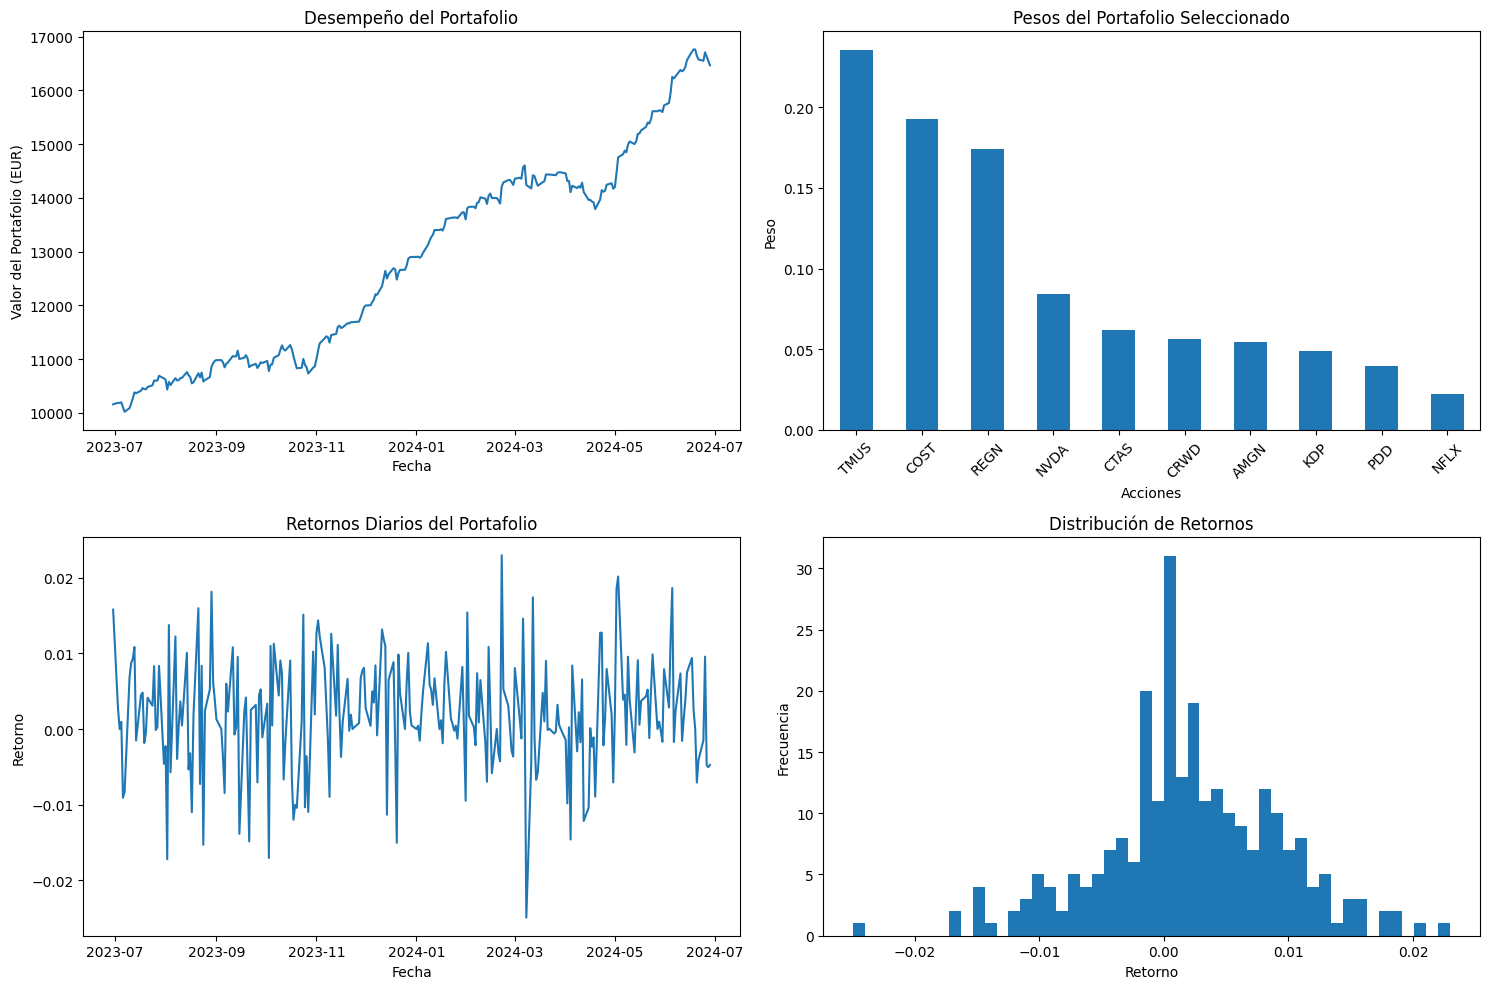

Retorno anual: 48.86%
Volatilidad anual: 11.58%
Ratio de Sharpe: 4.13
Valor final del portafolio: 16465.13 EUR

Activos en el portafolio:
TMUS: 23.53%
COST: 19.28%
REGN: 17.42%
NVDA: 8.40%
CTAS: 6.21%
CRWD: 5.65%
AMGN: 5.44%
KDP: 4.91%
PDD: 3.99%
NFLX: 2.20%


In [5]:




nasdaq_symbols_list = stock_names

# Descargar datos

data, failed_symbols = download_data(nasdaq_symbols_list, start_date, end_date, '1d')

# Alinear fechas y llenar NaN
aligned_data = []
for symbol, df in data.items():
    df = df.reindex(pd.date_range(start=start_date, end=end_date, freq='B'))  # Reindexar al rango de fechas completo
    df.ffill(inplace=True)  # Forward fill
    df.bfill(inplace=True)  # Backward fill
    aligned_data.append(df)

# Concatenar los datos alineados
df = pd.concat(aligned_data, axis=1, keys=data.keys())

returns = df.pct_change().dropna()

# Optimizar portafolio
optimal_weights = optimize_portfolio(returns)






# Guardar los pesos del portafolio en un archivo CSV
weights_series = pd.Series(optimal_weights, index=returns.columns)
# Filtrar los pesos mayores a minimun_weight
filtered_weights = weights_series[weights_series > minimun_weight]

filtered_weights = filtered_weights.sort_values(ascending=False)
print(filtered_weights)


# Calcular métricas del portafolio usando solo los pesos filtrados
filtered_returns = returns[filtered_weights.index]
normalized_weights = filtered_weights / filtered_weights.sum()

portfolio_returns = pd.Series(np.dot(filtered_returns, normalized_weights), index=filtered_returns.index)
annual_return, annual_volatility = portfolio_performance(normalized_weights, filtered_returns)
sharpe_ratio = (annual_return - 0.01) / annual_volatility

print(f"Retorno anual: {annual_return:.4f}")
print(f"Volatilidad anual: {annual_volatility:.4f}")
print(f"Ratio de Sharpe: {sharpe_ratio:.4f}")

# Calcular R2
time = np.arange(len(portfolio_returns))
slope, intercept = np.polyfit(time, portfolio_returns, 1)
line = slope * time + intercept
r2 = r2_score(portfolio_returns, line)

# Simulación del portafolio
portfolio_values = initial_capital * (1 + portfolio_returns).cumprod()

# Visualización de resultados
plt.figure(figsize=(15, 10))

# Gráfico de desempeño del portafolio
plt.subplot(2, 2, 1)
plt.plot(portfolio_values.index, portfolio_values)
plt.title('Desempeño del Portafolio')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio (EUR)')

# Gráfico de pesos del portafolio
plt.subplot(2, 2, 2)
filtered_weights.sort_values(ascending=False).plot(kind='bar')
plt.title('Pesos del Portafolio Seleccionado')
plt.xlabel('Acciones')
plt.ylabel('Peso')
plt.xticks(rotation=45)

# Gráfico de retornos diarios
plt.subplot(2, 2, 3)
plt.plot(portfolio_returns.index, portfolio_returns)
plt.title('Retornos Diarios del Portafolio')
plt.xlabel('Fecha')
plt.ylabel('Retorno')

# Histograma de retornos
plt.subplot(2, 2, 4)
plt.hist(portfolio_returns, bins=50)
plt.title('Distribución de Retornos')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Imprimir métricas

print(f"Retorno anual: {annual_return:.2%}")
print(f"Volatilidad anual: {annual_volatility:.2%}")
print(f"Ratio de Sharpe: {sharpe_ratio:.2f}")
print(f"Valor final del portafolio: {portfolio_values.iloc[-1]:.2f} EUR")

print("\nActivos en el portafolio:")
for symbol, weight in filtered_weights.items():
    print(f"{symbol}: {weight:.2%}")

## 6. 🚀 Production
ALPACA API

In [ ]:

# Configuración de la API de Alpaca
API_KEY = 'XXX'
API_SECRET = 'XXX'
BASE_URL = 'https://paper-api.alpaca.markets'  # Usa esta URL para paper trading
ap = tradeapi.REST(API_KEY, API_SECRET, BASE_URL)
api = TradingClient(api_key=API_KEY, secret_key=API_SECRET, paper=True)

In [ ]:
ap.submit_order(symbol="TSLA", notional=100, side="buy", type="market", time_in_force="day" )

### Bot

In [ ]:



def get_portfolio_value():
    account = api.get_account()
    return float(account.portfolio_value)

def get_current_price(symbol):

    bars = ap.get_latest_bar(symbol)
    return bars.c
def optimize_and_save_portfolio():

    nasdaq_symbols_list = stock_names

    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
    end_date = datetime.now().strftime('%Y-%m-%d')

    data, failed_symbols = download_data(nasdaq_symbols_list, start_date, end_date, '1d')
    # Alinear fechas y llenar NaN
    aligned_data = []
    for symbol, df in data.items():
        df = df.reindex(pd.date_range(start=start_date, end=end_date, freq='B'))  # Reindexar al rango de fechas completo
        df.ffill(inplace=True)  # Forward fill
        df.bfill(inplace=True)  # Backward fill
        aligned_data.append(df)

    # Concatenar los datos alineados
    df = pd.concat(aligned_data, axis=1, keys=data.keys())

    returns = df.pct_change().dropna()


    # Optimizar portafolio usando bootstrapping y algoritmo genético


    optimal_weights = optimize_portfolio(returns)


    # Guardar los pesos del portafolio en un archivo CSV
    weights_series = pd.Series(optimal_weights, index=returns.columns)
    # Filtrar los pesos mayores a minimun_weight
    filtered_weights = weights_series[weights_series > minimun_weight]

    filtered_weights = filtered_weights.sort_values(ascending=False)
    print(filtered_weights)
    weights_df = filtered_weights.reset_index()
    weights_df.columns = ['symbol', 'weight']

    weights_df.to_csv('portfolio_weights.csv', index=False)

    print("Archivo CSV con los pesos del portafolio guardado como 'portfolio_weights.csv'")

def sell_all_positions():

    positions = api.get_all_positions()
    api.cancel_orders()
    for position in positions:
        api.submit_order(MarketOrderRequest(
            symbol=position.symbol,
            qty=position.qty,
            side=OrderSide.SELL,
            type=OrderType.MARKET,
            time_in_force=TimeInForce.DAY
        ))
        print(f"Vendiendo todas las acciones de {position.symbol}")

def buy_new_portfolio():
    portfolio_value = get_portfolio_value()
    portfolio_weights = pd.read_csv('portfolio_weights.csv', index_col='symbol')['weight']

    for symbol, weight in portfolio_weights.items():
        try:
            target_value = weight * portfolio_value
            current_price = get_current_price(symbol)
            qty = target_value / current_price

            api.submit_order(MarketOrderRequest(
                symbol=symbol,
                notional=round(target_value, 2),
                side=OrderSide.BUY,
                type=OrderType.MARKET,
                time_in_force=TimeInForce.DAY
            ))
            print(f"Comprando {qty:.2f} acciones de {symbol}. TOTAL= {round(target_value, 2)}")

        except Exception as e:
            print(f"Error al operar con {symbol}: {str(e)}")

def run_trading_strategy():
    optimization_interval = 60*60*24*3  # ⚠⚠⚠ ¿Cada cuanto se hace la optimizacion?

    # Optimización inicial
    optimize_and_save_portfolio()
    sell_all_positions()
    buy_new_portfolio()

    last_optimization = datetime.now()

    while True:
        try:
            current_time = datetime.now()
            time_since_optimization = (current_time - last_optimization).total_seconds()

            print(f"Tiempo actual: {current_time}")
            print(f"Tiempo desde última optimización: {time_since_optimization:.2f} segundos")

            if time_since_optimization >= optimization_interval:
                print("Optimizando y rebalanceando portafolio...")
                optimize_and_save_portfolio()

                sell_all_positions()
                buy_new_portfolio()
                last_optimization = current_time
                print(f"Optimización y rebalanceo completados. Próxima optimización en {optimization_interval} segundos.")
            else:
                print("No se requiere acción en este momento.")

            print("--------------------")
            time.sleep(60*60*24)  # ⚠⚠⚠ ¿Cada cuanto quiero comprobar?

        except Exception as e:
            print(f"Error general: {str(e)}")
            time.sleep(30)  # ⚠⚠⚠ Fallo en la llamada, volver a intentarlo.

if __name__ == "__main__":
    api.cancel_orders()
    run_trading_strategy()